# Практическое задание 3

### 1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=-1,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf, f1_test

In [2]:
%%time
dataset = pd.read_csv('../dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

Wall time: 4.19 s


In [3]:
# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

#### Обучение на всех признаках

In [4]:
%%time
f1_dict = {}
fitted_clf, f1_dict['All Features'] = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = pd.DataFrame(list(zip(X.columns, fitted_clf.feature_importances_))).sort_values(by=1, ascending=False)

Precision: 0.29018008834522596
Recall: 0.4117647058823529
F1: 0.34044249551524813
Log Loss: 0.13302204579521332
ROC AUC: 0.8988174732667378
Wall time: 11.5 s


#### XGB Feature Importance

In [5]:
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_FI, f1_dict['Feature Importance'] = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.2936897042543097
Recall: 0.44768563162970104
F1: 0.35469391653137233
Log Loss: 0.1324919144007441
ROC AUC: 0.8987254917833496
Признаков было: 60
Признаков стало: 30


#### Взаимная информация

In [6]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

Wall time: 1min 37s


In [7]:
feature_importance = pd.DataFrame(list(zip(X.columns, mi))).sort_values(by=1, ascending=False)

In [8]:
X_train_MI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_MI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf_MI, f1_dict['Mutual Information'] = xgb_fit_predict(X_train_MI, y_train_balanced, X_test_MI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_MI.shape[1])

Precision: 0.29387113672079623
Recall: 0.4057377049180328
F1: 0.3408607594936709
Log Loss: 0.13345062550469272
ROC AUC: 0.8941616294615592
Признаков было: 60
Признаков стало: 30


#### RFE (Recursive Feature Elimination)

In [9]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1', n_jobs=-1)
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 50
Wall time: 1min 10s


In [10]:
X_train_RFE = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features]
X_test_RFE = pd.DataFrame(X_test, columns=X.columns)[good_features]

fitted_clf_RFE, f1_dict['Recursive Feature Elimination'] = xgb_fit_predict(X_train_RFE, y_train_balanced, X_test_RFE, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_RFE.shape[1])

Precision: 0.2903817302883814
Recall: 0.41996142719382834
F1: 0.3433527150882034
Log Loss: 0.13385199911487985
ROC AUC: 0.8973120356107466
Признаков было: 60
Признаков стало: 50


#### Permutation Importance (PI)

In [11]:
from eli5.sklearn import PermutationImportance

In [12]:
%%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train_balanced, y_train_balanced)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

Wall time: 1min 1s


In [14]:
good_features_PI = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features_PI.shape[0])

Кол-во отобранных признаков: 40


In [15]:
X_train_PI = pd.DataFrame(X_train_balanced, columns=X.columns)[good_features_PI]
X_test_PI = pd.DataFrame(X_test, columns=X.columns)[good_features_PI]

fitted_clf_PI, f1_dict['Permutation Importance'] = xgb_fit_predict(X_train_PI, y_train_balanced, X_test_PI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_PI.shape[1])

Precision: 0.2912487028709789
Recall: 0.4059787849566056
F1: 0.3391742195367573
Log Loss: 0.13407655775844182
ROC AUC: 0.8956549694656641
Признаков было: 60
Признаков стало: 40


#### Результаты

In [20]:
f1_dict

{'All Features': 0.34044249551524813,
 'Feature Importance': 0.35469391653137233,
 'Mutual Information': 0.3408607594936709,
 'Recursive Feature Elimination': 0.3433527150882034,
 'Permutation Importance': 0.3391742195367573}

Встроенный метод XGBoost feature impoirtance в данном примере показал себя лучше других методов, несмотря на отсеивание половины признаков.

### 2. Обучите любые две другие модели для предсказания оттока на любом из отобранных множеств признаков и сравните качество с уже полученными.

Метрики полученные для модели **XGBoost** для дальнейшего сравнения

* Precision: 0.2936897042543097
* Recall: 0.44768563162970104
* F1: 0.35469391653137233
* Log Loss: 0.1324919144007441
* ROC AUC: 0.8987254917833496

#### CatBoost

In [22]:
from catboost import CatBoostClassifier

In [38]:
%%time
catboost_clf = CatBoostClassifier(iterations=300,
                                  depth=5,
                                  learning_rate=1e-2,
                                  silent=True,
                                  random_state=42,
                                  thread_count=-1)

catboost_clf.fit(X_train_FI, y_train_balanced)
predict_proba_test = catboost_clf.predict_proba(X_test_FI)
predict_test = catboost_clf.predict(X_test_FI)
metrics = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.30644889712072737
Recall: 0.43876567020250723
F1: 0.3608605135322692
Log Loss: 0.1433888981461089
ROC AUC: 0.8977325266750622
Wall time: 12.4 s


#### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
%%time
rfc_clf = RandomForestClassifier(n_estimators=200,
                                 max_depth=7,
                                 min_samples_split=10,
                                 random_state=42,
                                 n_jobs=-1)

rfc_clf.fit(X_train_FI, y_train_balanced)
predict_proba_test = rfc_clf.predict_proba(X_test_FI)
predict_test = rfc_clf.predict(X_test_FI)
metrics = evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.2719451371571072
Recall: 0.5257955641272902
F1: 0.3584812623274162
Log Loss: 0.16150737452354733
ROC AUC: 0.9068390374392477
Wall time: 19.8 s


#### Результаты
Значения метрик очень близки для всех трех моделей.

По F1 выиграл **CatBoost**.

По Log Loss **XGBoost**

Площадь под ROC-кривой больше у **RFC**

Если, конечно, тщательно подбирать гиперпараметры, то для каждой модели можно будет получить значения метрик получше и, возможно, мы сможем уверенно выбрать одну для нашей задачи.

### 3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [41]:
import seaborn as sns

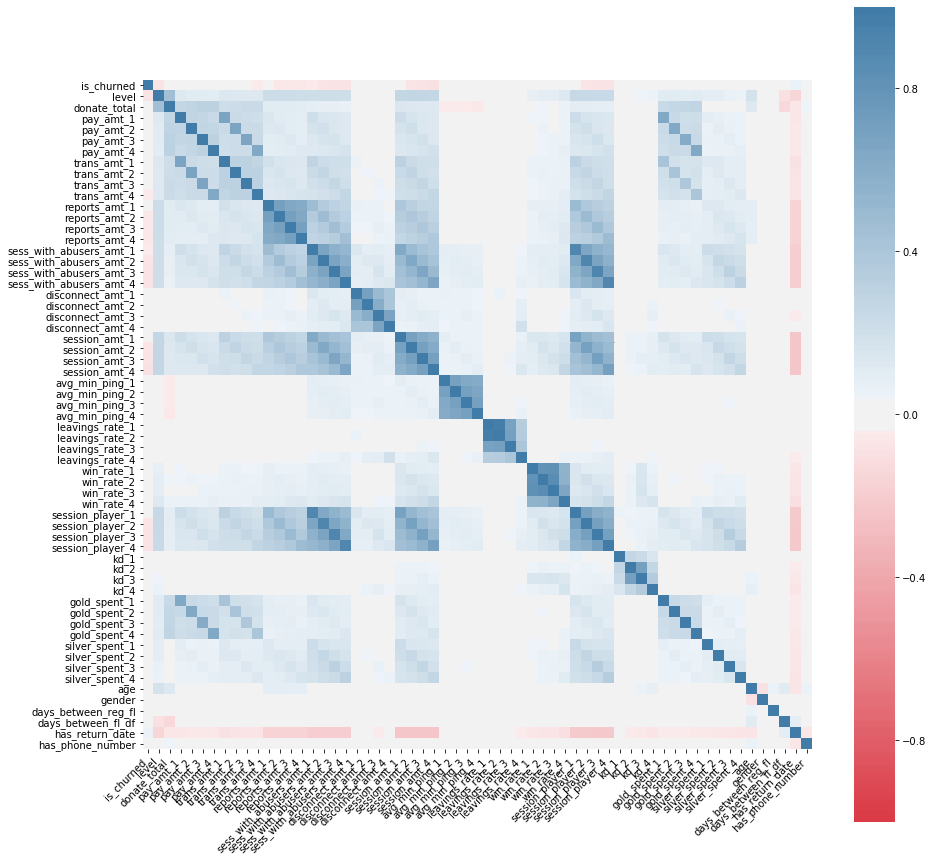

In [43]:
corr = dataset.drop(['user_id'], axis=1).corr()

plt.figure(figsize=(15, 15))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 240, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

Покажем на графике в порядке убывания признаки наиболее коррелирующие с целевым признаком **is_churned**

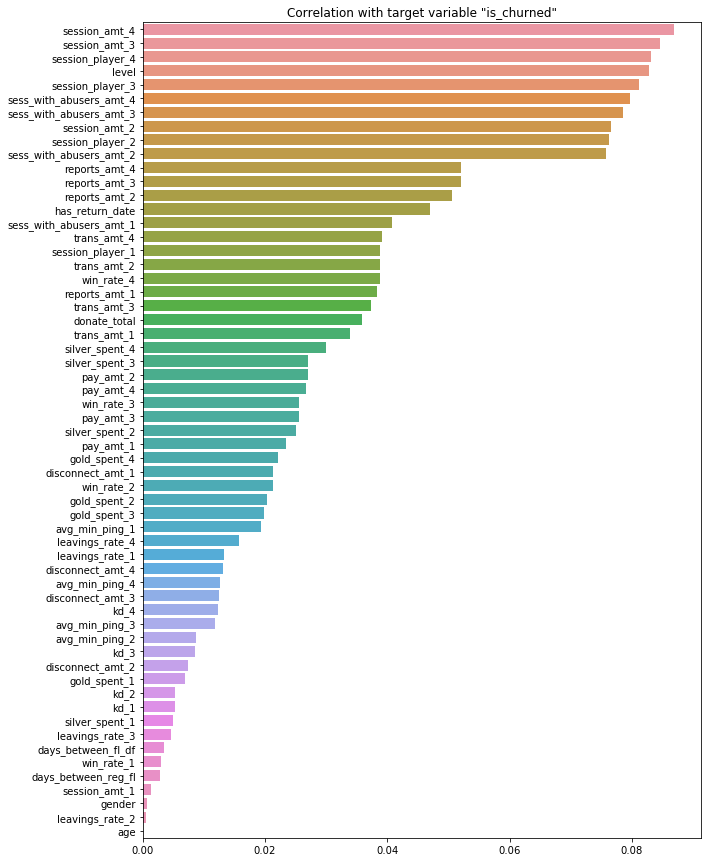

In [64]:
corr_with_target = np.abs(corr.iloc[:-1, 0].drop('is_churned')).sort_values(ascending=False)

plt.figure(figsize=(10, 15))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable "is_churned"')
plt.show()

В качестве лучших признаков выберем, например, 35 наиболее коррелирующих с целевой переменной. И проверим для них результат с помощью уже готовой функции обучения XGBoost с урока.

In [74]:
X_train_CORR = pd.DataFrame(X_train_balanced, columns=X.columns)[corr_with_target[:35].index]
X_test_CORR = pd.DataFrame(X_test, columns=X.columns)[corr_with_target[:35].index]

fitted_clf_CORR, f1_dict['Correlation'] = xgb_fit_predict(X_train_CORR, y_train_balanced, X_test_CORR, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_CORR.shape[1])

Precision: 0.28803861970320044
Recall: 0.38837994214079075
F1: 0.33076686171850944
Log Loss: 0.14399806704244253
ROC AUC: 0.8379618769559369
Признаков было: 60
Признаков стало: 35


Результат средний.